In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
import time
import glob
import random
from random import choices

In [2]:
## Load hits (or compounds of interest, e.g. non-hits)
total_hits = []
total_smi = []
smi_lib=[]
total_activity = []

for file in glob.glob("./hits.csv"):
    fopen = open(file);
    for line in fopen.readlines():
        y = [value for value in line.split('\n')]
        y = y[0].split(",")
        try: 
            m = Chem.MolFromSmiles(y[0].replace('"',''))
            if m is not None:
                total_hits.append(m)
                total_smi.append(y[0].replace('"',''))
                smi_lib.append(y[1].replace('"','') == "MCULE")
                total_activity.append(y[2])
        except:
            x=1;
    fopen.close()
# 0.8, 0.8

RDKit ERROR: [01:56:14] SMILES Parse Error: syntax error while parsing: SMILES
[01:56:14] SMILES Parse Error: syntax error while parsing: SMILES
RDKit ERROR: [01:56:14] SMILES Parse Error: Failed parsing SMILES '﻿SMILES' for input: '﻿SMILES'
[01:56:14] SMILES Parse Error: Failed parsing SMILES '﻿SMILES' for input: '﻿SMILES'


In [3]:
## Check number of hits
len(total_hits)

3646

In [4]:
### User-defined parameters
N0 = 12 # Low atom threshold in any MCS
N1 = 40 # High atom threshold in any MCS
NUM_GROUPS = 5 # Number of different MCS-based groups to try
NUM_ITER = 1000 # Number of pairs to test in each run


### Main MCS computation and mining script ###
start_time = time.time()

# Define some lists to hold variables of interest
TOPLIST = []
TOPLIST_IDX = []
ASSOCIATED_NUMs =[ ]
ASSOCIATED_MOLS=[]
HITS_LEFT=[]
TRIED = []

for IT in range(NUM_GROUPS):
    toplist = []
    toplist_idx = []
    hits_associated = []
    associated_nums = []
    associated_mols = []
    tried = []
    hits_left = [(total_hits[i],i) for i in range(0,len(total_hits))] # Keep a tally of the hits not in any MCS

    for ITER in range(NUM_ITER):
        yy = random.sample(range(0, len(hits_left)), 2); # Sample two remaining hits at random
        if yy in tried:
            continue
        tried.append(yy)
        
        # Calculate MCS of two hits
        this_MCS = Chem.MolFromSmarts(rdFMCS.FindMCS([hits_left[x][0] for x in yy],timeout=1,bondCompare=rdFMCS.BondCompare.CompareOrderExact,completeRingsOnly=True).smartsString);
        this_idx = [hits_left[x][1] for x in yy];

        if this_MCS.GetNumAtoms() < N0 or this_MCS.GetNumAtoms() > N1:
            continue
        toplist.append(this_MCS) # try out MCS by tentatively adding it to list
        toplist_idx.append(this_idx)
        associated_nums.append(0)
        associated_mols.append([])
        hits_left_update = []

        # Check if other hits contain MCS using HasSubstructMatch()
        for i in range(len(hits_left)):
            test_mol = hits_left[i][0]
            test_MCS = toplist[-1]
            
            if test_mol.HasSubstructMatch(test_MCS): 
                associated_nums[-1] = associated_nums[-1] + 1
                associated_mols[-1].append(hits_left[i][1])
                hits_associated.append(hits_left[i][0])
            else:
                hits_left_update.append(hits_left[i])

        if associated_nums[-1] == 0: # useless MCS
            associated_nums.pop()
            associated_mols.pop()
            toplist.pop()
            toplist_idx.pop()

        hits_left = hits_left_update

    TOPLIST.append(toplist)
    TOPLIST_IDX.append(toplist_idx)
    ASSOCIATED_NUMs.append(associated_nums)
    ASSOCIATED_MOLS.append(associated_mols)
    HITS_LEFT.append(hits_left)
    TRIED.append(tried)

print("--- %s seconds ---" % (time.time() - start_time))

--- 32.85809016227722 seconds ---


Number of compounds: 3646
Number of associated compounds in each group: [120, 170, 578, 7, 118, 46, 173, 68, 3, 56, 8, 19, 29, 7, 17]
Total number of associated compounds in all groups: 1419
Number of remaining compounds: 2227


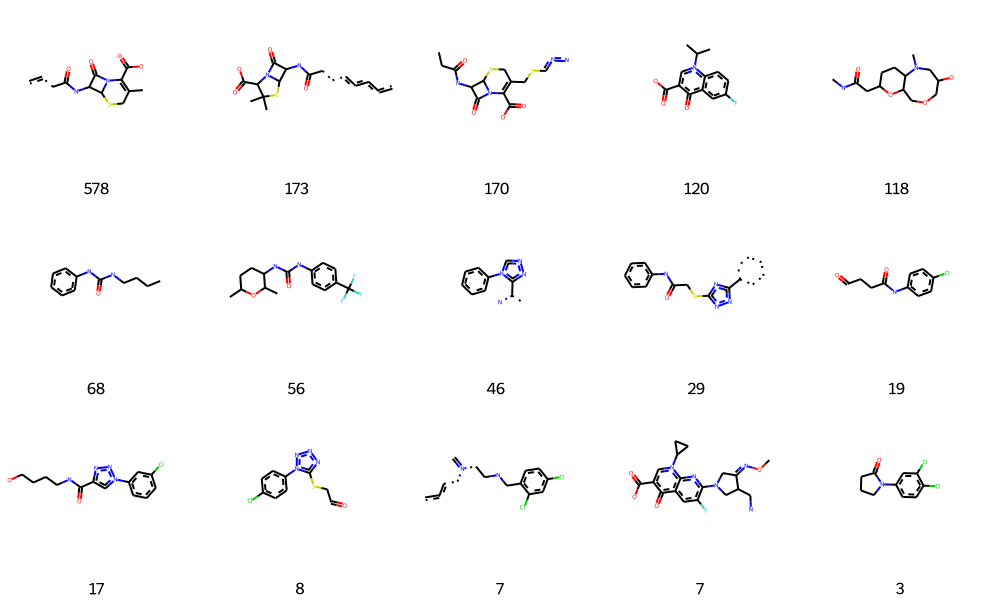

In [5]:
idx = 0 # Number of grouping to show, between 0 and NUM_GROUPS-1

### Show groups ###
toplist = TOPLIST[idx]
toplist_idx = TOPLIST_IDX[idx]
associated_nums = ASSOCIATED_NUMs[idx]
associated_mols = ASSOCIATED_MOLS[idx]
hits_left = HITS_LEFT[idx]

#print(ITER)
print("Number of compounds:",len(total_hits))  # all mols
print("Number of associated compounds in each group:", associated_nums)
print("Total number of associated compounds in all groups:", sum(associated_nums)) # associated
print("Number of remaining compounds:", len(hits_left)) # unassociated mols

redrawTL = []
for x in toplist_idx:
    ss = []
    for i in x:
        ss.append(total_hits[i])
    redrawTL.append(Chem.MolFromSmarts(rdFMCS.FindMCS(ss,timeout=1).smartsString))

srt=sorted(zip(associated_nums,range(len(associated_nums))),reverse=True)
Draw.DrawingOptions.atomLabelFontSize =30
img=Draw.MolsToGridImage([redrawTL[ss[1]] for ss in srt], molsPerRow=5,maxMols=1000,legends=[str(ss[0]) for ss in srt], useSVG=True)
img